# Classifying Simple Shapes With RBM
Raj Prasad
June 2019


[html version](https://daddyprasad5.github.io/rbm_shape_classification.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/rbm_shape_classification.ipynb) - with all the code exposed in an interactive notebook

This is a re-working of scikit learn's toy Restricted Boltzmann Machine (RBM) example.  The authors of the original example are Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve.  The example used RBM to create a feature that was in turn used by a logistic regression model to categorize images of hand-written digits.  

This re-purposing uses the same pipeline with re-tuned hyper-parameters.  I'm running that pipeline on images of shapes.  There are four different shapes - circle, triangle, square and star.  See details on the dataset here:  [four shapes data](https://www.kaggle.com/smeschke/four-shapes).  The data was developed by "smeschke" on kaggle.

The pipeline worked very well - even on much reduced image resolution.  The original images were 200X200, and the models were trained and tested on images reduced to 69X69.  None-the-less the classification of the stacked RBM/logistic regression model pipeline on the test dataset was perfect - slightly better than the logistic regression alone.  

In [2]:
%matplotlib inline

In [4]:
#docs and imports
# 
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import cv2
import os

Automatically created module for IPython interactive environment


In [17]:
#NOT USED - INCLUDED FOR REFERENCE ONLY...setup for the handwriting recognition


# #############################################################################
# Setting up

# def nudge_dataset(X, Y):
#     """
#     This produces a dataset 5 times bigger than the original one,
#     by moving the 8x8 images in X around by 1px to left, right, down, up
#     """
#     direction_vectors = [
#         [[0, 1, 0],
#          [0, 0, 0],
#          [0, 0, 0]],

#         [[0, 0, 0],
#          [1, 0, 0],
#          [0, 0, 0]],

#         [[0, 0, 0],
#          [0, 0, 1],
#          [0, 0, 0]],

#         [[0, 0, 0],
#          [0, 0, 0],
#          [0, 1, 0]]]

#     def shift(x, w):
#         return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

#     X = np.concatenate([X] +
#                        [np.apply_along_axis(shift, 1, X, vector)
#                         for vector in direction_vectors])
#     Y = np.concatenate([Y for _ in range(5)], axis=0)
#     return X, Y


# # Load Data
# digits = datasets.load_digits()
# X = np.asarray(digits.data, 'float32')
# X, Y = nudge_dataset(X, digits.target)
# X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

# X_train, X_test, Y_train, Y_test = train_test_split(
#     X, Y, test_size=0.2, random_state=0)




In [5]:
#setup for image recognition - this is the new bit... 

#create lists to save the labels (the name of the shape)
labels, images, shape_dir = [],[], 'shapes/'
shapes = ['square', 'circle', 'star', 'triangle']

#iterate through each shape
for shape in shapes:
    print('Getting data for: ', shape)
    #iterate through each file in the folder
    for path in os.listdir(shape_dir+shape):
        #add the image to the list of images
        images.append(cv2.imread(shape_dir+shape+'/'+path, 0))
        #add an integer to the labels list 
        labels.append(shapes.index(shape))


Getting data for:  square
Getting data for:  circle
Getting data for:  star
Getting data for:  triangle


In [92]:
# functions

import math

# #############################################################################
# Plotting
def plot_shape(image):
    print(image.shape)
    dim = int(math.sqrt(len(image)))
    plt.imshow(image.reshape((dim, dim)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    
#reduce image size to 1/ratio
def reduce_image(image, ratio):
    new_image = []
    for dim in range(200):
        if (dim % ratio) == 0:  #take ever ratioth row
            new_image_dim = []
            for index, pixel in enumerate(image[dim]):
                if (index % ratio) == 0:
                    new_image_dim.append(pixel)
            new_image.append(new_image_dim)
    return np.array(new_image)


In [94]:
#flatten & reduce images
flat_images = [reduce_image(image, 16).flatten() for image in images]

(40000,)


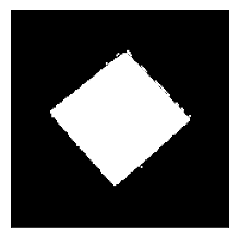

(169,)


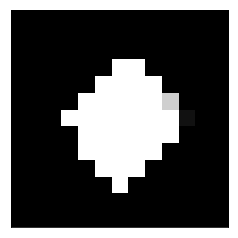

In [103]:
#before and after reduction
plot_shape(images[0].flatten())
plot_shape(flat_images[0])

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(
    flat_images, labels, test_size=0.2, random_state=0)

print('Number of training images: ', len(X_train))
print('Number of test images: ', len(X_test))


Number of training images:  11976
Number of test images:  2994


In [105]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [147]:
#training:  the hyperparameters are altered.  
#As compared to the hand-writing exercise, the rbm learning_rate needed to be much lower,
#and only one iteration was needed
#and a higher number of components drove much improved accuracy

rbm.learning_rate = .00000000000001
rbm.n_iter = 1
rbm.n_components = 400
logistic.C = 100

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -3776.00, time = 2.88s


Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=1e-14, n_components=400, n_iter=1,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=1, verbose=0, warm_start=False))])

In [107]:
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=1, verbose=0, warm_start=False)

In [148]:
#evaluation

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))



Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       718
           1       1.00      1.00      1.00       751
           2       1.00      1.00      1.00       748
           3       1.00      1.00      1.00       777

   micro avg       1.00      1.00      1.00      2994
   macro avg       1.00      1.00      1.00      2994
weighted avg       1.00      1.00      1.00      2994


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       718
           1       0.97      0.97      0.97       751
           2       1.00      1.00      1.00       748
           3       1.00      1.00      1.00       777

   micro avg       0.98      0.98      0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994




400


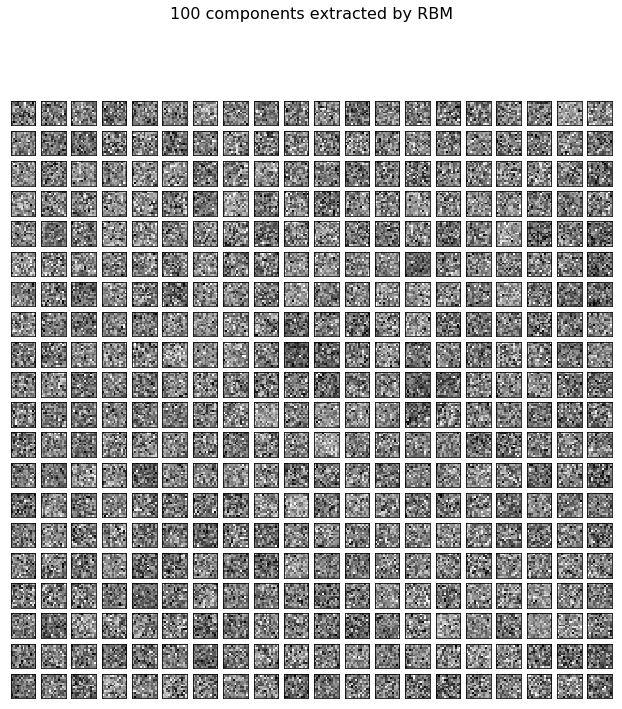

In [149]:
#plotting

# #############################################################################
# Plotting
dim = round(math.ceil(math.sqrt(len(rbm.components_))))
plt.figure(figsize=(10, 10))
print(len(rbm.components_))
for i, comp in enumerate(rbm.components_):
    plt.subplot(dim, dim, i+1)
    plt.imshow(comp.reshape((13, 13)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()